In [85]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [86]:
%matplotlib inline

import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.decoding import CSP

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

from glob import glob

from scipy.signal import butter, lfilter, convolve, boxcar
from joblib import Parallel, delayed

import theano
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator
from theano.tensor.nnet import sigmoid
from lasagne.layers import InputLayer, DropoutLayer, DenseLayer,Conv1DLayer, Conv2DLayer, MaxPool1DLayer

Create function to generate mne object (http://martinos.org/mne/stable/mne-python.html) from input data.
1. read csv as panda data frame.
2. extract channel names and recover local configuration (montage) and set channel type to eeg.
3. If specified (read_events=True): add events as stim channels values to data.
4. Generate meta data (info) for mne object and instanciate object from data and info.

In [87]:
def create_mne_raw_object(fname,read_events=True):
    """Create a mne raw instance from csv file"""
    # Read EEG file
    data = pd.read_csv(fname)

    # get chanel names
    ch_names = list(data.columns[1:])

    # read EEG standard montage from mne
    montage = read_montage('standard_1005',ch_names)

    ch_type = ['eeg']*len(ch_names)
    data = 1e-6*np.array(data[ch_names]).T

    if read_events:
        # events file
        ev_fname = fname.replace('_data','_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T

        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data
        data = np.concatenate((data,events_data))

    # create and populate MNE info structure
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
    info['filename'] = fname

    # create raw object
    raw = RawArray(data,info,verbose=False)

    return raw

Specify input parameters:
1. Number of subjects to predict.
2. Filter in frequency domain to retain frequencies of interest (7-30Hz): Butterworth bandpass filter (https://en.wikipedia.org/wiki/Butterworth_filter) to denoise signal.
3. Linearly transform data to maximize the variance differences upon stimuli using common spatial pattern (CSP, https://www.youtube.com/watch?v=zsOULC16USU). Very similar to PCA with another rotation to one principal component.

In [88]:
SUBJECTS = range(1,13)

# design a butterworth bandpass filter
#freqs = [7, 30]
FREQS = [6, 30]
b,a = butter(5,np.array(FREQS)/250.0,btype='bandpass')

# CSP parameters
# Number of spatial filter to use
NFILTERS = 4

# convolution
# window for smoothing features
NWIN = 250

# training subsample
SUBSAMPLE = 10



# submission file
submission_file = 'submission.csv'
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

Read the training data or test data for a given subject. 

In [89]:
def read_training_data(subject, series): 
    """
    Reads the training data for a given subject.
    subject = subject_index
    """
    print('Reading subject %d data' % (subject))
    ################ READ DATA ###############################################
    fnames =  glob('input/train/subj%d_series%s_data.csv' % (subject, series))

    # read and concatenate all the files
    raw = concatenate_raws([create_mne_raw_object(fname) for fname in fnames])
    # pick eeg signal
    picks = pick_types(raw.info,eeg=True)
    
    # Filter data for alpha frequency and beta band
    # Note that MNE implement a zero phase (filtfilt) filtering not compatible
    # with the rule of future data.
    # Here we use left filter compatible with this constraint.
    # The function parallelized for speeding up the script
    raw._data[picks] = np.array(Parallel(n_jobs=-1)(delayed(lfilter)(b,a,raw._data[i]) for i in picks))
    print('Reading subject %d data. Done.' % (subject))
    return raw

def read_test_data(subject): 
    """
    Reads the test data for a given subject.
    subject = subject_index
    """
    print('Reading subject %d test data' % (subject))
    ################ READ DATA ###############################################
    # read test data
    fnames =  glob('input/test/subj%d_series*_data.csv' % (subject))
    raw = concatenate_raws([create_mne_raw_object(fname, read_events=False) for fname in fnames])
    picks = pick_types(raw.info,eeg=True)
    raw._data[picks] = np.array(Parallel(n_jobs=-1)(delayed(lfilter)(b,a,raw._data[i]) for i in picks))
    print('Reading subject %d test data. Done.' % (subject))
    return raw

def read_test_ids(subject): 
    """
    read test ids for subject
    """
    print('Reading subject %d test ids' % (subject))
    # read ids
    fnames =  glob('input/test/subj%d_series*_data.csv' % (subject))
    ids = np.concatenate([np.array(pd.read_csv(fname)['id']) for fname in fnames])
    print('Reading subject %d test ids. Done.' % (subject))
    return ids

Learn and perform CSP filter. 

In [90]:
def learn_csp_filter(raw, stim_channel='Replace'):
    """
    Trains CSP filter on the data. It optimizes the separation of variance between the two epochs 1.5s before
    and after the defined stim_channel. 
    """
    print('Learning CSP for stim_channel %s' % (stim_channel))
    
    epochs_tot = []
    picks = pick_types(raw.info,eeg=True)
    
    ################ CSP Filters training #####################################
    # get event position corresponding to Replace
    events = find_events(raw,stim_channel='Replace', verbose=False)
    # epochs signal for 1.5 second before the movement
    # add data, events, id, time_start and time_end
    epochs = Epochs(raw, events, {'during' : 1}, -2, -0.5, proj=False,
                    picks=picks, baseline=None, preload=True,
                    add_eeg_ref=False, verbose=False)
    epochs_tot.append(epochs)
    y = []
    y.extend([1]*len(epochs))
    # epochs signal for 1.5 second after the movement, this correspond to the
    # rest period.
    epochs_rest = Epochs(raw, events, {'after' : 1}, 0.5, 2, proj=False,
                    picks=picks, baseline=None, preload=True,
                    add_eeg_ref=False, verbose=False)
    # Workaround to be able to concatenate epochs with MNE
    epochs_rest.times = epochs.times

    y.extend([-1]*len(epochs_rest))
    epochs_tot.append(epochs_rest)

    # Concatenate all epochs
    epochs = concatenate_epochs(epochs_tot)
    
    # get data
    X = epochs.get_data()
    y = np.array(y)

    # train CSP
    csp = CSP(n_components=NFILTERS, reg='lws')
    csp.fit(X,y)
    
    print('Learning CSP for stim_channel %s. Done.' % (stim_channel))
    
    return csp 

def perform_csp_filter(raw, csp):
    """
    Filters the raw data with the specified, trained csp filter.
    """
    print('Filter raw data with csp filter.')
    picks = pick_types(raw.info,eeg=True)
    feat = np.dot(csp.filters_[0:NFILTERS],raw._data[picks])**2
    print('Filter raw data with csp filter. Done.')
    return feat

def perform_smoothing(feat, NWIN, NFILTERS):
    """
    Smoothes features with a box kernel of size nwin. 
    """
    print('Convolve features for smoothing.')
    feat_convolved = np.array(Parallel(n_jobs=-1)(delayed(convolve)(feat[i],boxcar(NWIN),'full') for i in range(NFILTERS)))
    feat_convolved = np.log(feat_convolved[:,0:feat.shape[1]])
    print('Convolve features for smoothing. Done.')
    return feat_convolved

In [91]:
def normalize_train_and_test(raw_train, raw_test): 
    
    #means = np.mean(raw_train._data[:32], axis=1)
    #raw_train._data[:32] = np.subtract(raw_train._data[:32].T, means).T
    #raw_test._data[:32] = np.subtract(raw_test._data[:32].T, means).T
    
    #stds = np.std(raw_train._data[:32], axis=1)
    #raw_train._data[:32] = np.divide(raw_train._data[:32].T, stds).T
    #raw_test._data[:32] = np.divide(raw_test._data[:32].T, stds).T
    
    scaler = StandardScaler().fit(raw_train._data[:32])
    
    raw_train._data[:32] = scaler.transform(raw_train._data[:32])
    raw_test._data[:32] = scaler.transform(raw_test._data[:32])
    
    
    return(raw_train, raw_test)

def get_transformed_data(raw_train, raw_test, class_index):
    """
    Train filter for specific class and transform data. 
    """
    csp_filter = learn_csp_filter(raw_train, stim_channel=cols[class_index])
    
    # smoothing by convolution with a rectangle window
    feat_train = perform_csp_filter(raw_train, csp_filter)
    feat_train = perform_smoothing(feat_train, NWIN, NFILTERS)

    feat_test = perform_csp_filter(raw_test, csp_filter)
    feat_test = perform_smoothing(feat_test, NWIN, NFILTERS)
    
    return(feat_train, feat_test)
    
def train_scikit_learn(train, train_labels, test, model, params, verbose=True):
    """
    Trains a scikit model for each class
    """

    mod = GridSearchCV(model, params, cv=5, verbose=verbose, n_jobs=1, scoring='roc_auc')
    mod.fit(train[:,::SUBSAMPLE].T,train_labels[::SUBSAMPLE])
    print(mod.best_score_)
    print('Best score %.4e with parameters %s' % (mod.best_score_ ,mod.best_params_) )

    return(mod.predict_proba(test.T)[:,1])

def train_subject(subject, model, params):
    """
    Train nnet for single subject. 
    """
    raw_train = read_training_data(subject)
    raw_test = read_test_data(subject)

    test_ids = read_test_ids(subject)
    train_labels = raw_train._data[32:]
#    ids_tot.append(test_ids)
    
    pred = np.zeros((len(test_ids),6))
    
    for i in range(0,len(cols)): 
        print('Train subject %d, class %s' % (subject, cols[i]))
        train, test = get_transformed_data(raw_train, raw_test, i)
        pred[:,i] = train_scikit_learn(train, train_labels[i,:], test, model, params)
    
    return(test_ids, pred)

def train_all(submission_id='', model=LogisticRegression(), params={'C': [1.0]} ): 
    
    ids_all = []
    pred_all = []

    for i in SUBJECTS:
        test_ids, pred = train_subject(i, model, params)
        ids_all.append(test_ids)
        pred_all.append(pred)
    
    # create pandas object for sbmission
    submission = pd.DataFrame(index=np.concatenate(ids_all), columns=cols, data=np.concatenate(pred_all))
    
    # write file
    submission.to_csv( (('%s%s') %(submission_id, submission_file)),index_label='id',float_format='%.5f' )

In [126]:
train_all()

Reading subject 1 data
Reading subject 1 data. Done.
Reading subject 1 test data
Reading subject 1 test data. Done.
Reading subject 1 test ids
Reading subject 1 test ids. Done.
Train subject 1, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished



0.615682691844
Best score 6.1568e-01 with parameters {'C': 1.0}
Train subject 1, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.718260366507
Best score 7.1826e-01 with parameters {'C': 1.0}
Train subject 1, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.717694476262
Best score 7.1769e-01 with parameters {'C': 1.0}
Train subject 1, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.708797727079
Best score 7.0880e-01 with parameters {'C': 1.0}
Train subject 1, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.619572388541
Best score 6.1957e-01 with parameters {'C': 1.0}
Train subject 1, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.661430783688
Best score 6.6143e-01 with parameters {'C': 1.0}
Reading subject 2 data
Reading subject 2 data. Done.
Reading subject 2 test data
Reading subject 2 test data. Done.
Reading subject 2 test ids
Reading subject 2 test ids. Done.
Train subject 2, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished



0.630395235905
Best score 6.3040e-01 with parameters {'C': 1.0}
Train subject 2, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished



0.783640209268
Best score 7.8364e-01 with parameters {'C': 1.0}
Train subject 2, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished



0.782260403971
Best score 7.8226e-01 with parameters {'C': 1.0}
Train subject 2, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished



0.736605936913
Best score 7.3661e-01 with parameters {'C': 1.0}
Train subject 2, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished



0.721209233069
Best score 7.2121e-01 with parameters {'C': 1.0}
Train subject 2, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.3s finished



0.756271917519
Best score 7.5627e-01 with parameters {'C': 1.0}
Reading subject 3 data
Reading subject 3 data. Done.
Reading subject 3 test data
Reading subject 3 test data. Done.
Reading subject 3 test ids
Reading subject 3 test ids. Done.
Train subject 3, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.587732045421
Best score 5.8773e-01 with parameters {'C': 1.0}
Train subject 3, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.720637375356
Best score 7.2064e-01 with parameters {'C': 1.0}
Train subject 3, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.739559144688
Best score 7.3956e-01 with parameters {'C': 1.0}
Train subject 3, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.761569912696
Best score 7.6157e-01 with parameters {'C': 1.0}
Train subject 3, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.674766547598
Best score 6.7477e-01 with parameters {'C': 1.0}
Train subject 3, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.637460631646
Best score 6.3746e-01 with parameters {'C': 1.0}
Reading subject 4 data
Reading subject 4 data. Done.
Reading subject 4 test data
Reading subject 4 test data. Done.
Reading subject 4 test ids
Reading subject 4 test ids. Done.
Train subject 4, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.66665622692
Best score 6.6666e-01 with parameters {'C': 1.0}
Train subject 4, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.763068372997
Best score 7.6307e-01 with parameters {'C': 1.0}
Train subject 4, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.782678727564
Best score 7.8268e-01 with parameters {'C': 1.0}
Train subject 4, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.823587422685
Best score 8.2359e-01 with parameters {'C': 1.0}
Train subject 4, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.605486285707
Best score 6.0549e-01 with parameters {'C': 1.0}
Train subject 4, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.667633511994
Best score 6.6763e-01 with parameters {'C': 1.0}
Reading subject 5 data
Reading subject 5 data. Done.
Reading subject 5 test data
Reading subject 5 test data. Done.
Reading subject 5 test ids
Reading subject 5 test ids. Done.
Train subject 5, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.675112012169
Best score 6.7511e-01 with parameters {'C': 1.0}
Train subject 5, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.71605425077
Best score 7.1605e-01 with parameters {'C': 1.0}
Train subject 5, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished



0.68622465063
Best score 6.8622e-01 with parameters {'C': 1.0}
Train subject 5, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.617948076855
Best score 6.1795e-01 with parameters {'C': 1.0}
Train subject 5, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished



0.698547473415
Best score 6.9855e-01 with parameters {'C': 1.0}
Train subject 5, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.659433357802
Best score 6.5943e-01 with parameters {'C': 1.0}
Reading subject 6 data
Reading subject 6 data. Done.
Reading subject 6 test data
Reading subject 6 test data. Done.
Reading subject 6 test ids
Reading subject 6 test ids. Done.
Train subject 6, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished



0.59790161594
Best score 5.9790e-01 with parameters {'C': 1.0}
Train subject 6, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished



0.596060040611
Best score 5.9606e-01 with parameters {'C': 1.0}
Train subject 6, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.699043012294
Best score 6.9904e-01 with parameters {'C': 1.0}
Train subject 6, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished



0.548130009375
Best score 5.4813e-01 with parameters {'C': 1.0}
Train subject 6, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished



0.662517327891
Best score 6.6252e-01 with parameters {'C': 1.0}
Train subject 6, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished



0.650771966053
Best score 6.5077e-01 with parameters {'C': 1.0}
Reading subject 7 data
Reading subject 7 data. Done.
Reading subject 7 test data
Reading subject 7 test data. Done.
Reading subject 7 test ids
Reading subject 7 test ids. Done.
Train subject 7, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished



0.562882691573
Best score 5.6288e-01 with parameters {'C': 1.0}
Train subject 7, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished



0.810262156532
Best score 8.1026e-01 with parameters {'C': 1.0}
Train subject 7, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.851335187509
Best score 8.5134e-01 with parameters {'C': 1.0}
Train subject 7, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished



0.859105508225
Best score 8.5911e-01 with parameters {'C': 1.0}
Train subject 7, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.773876066532
Best score 7.7388e-01 with parameters {'C': 1.0}
Train subject 7, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.789570478848
Best score 7.8957e-01 with parameters {'C': 1.0}
Reading subject 8 data
Reading subject 8 data. Done.
Reading subject 8 test data
Reading subject 8 test data. Done.
Reading subject 8 test ids
Reading subject 8 test ids. Done.
Train subject 8, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.720483906134
Best score 7.2048e-01 with parameters {'C': 1.0}
Train subject 8, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.751775164953
Best score 7.5178e-01 with parameters {'C': 1.0}
Train subject 8, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.815690066142
Best score 8.1569e-01 with parameters {'C': 1.0}
Train subject 8, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.891656511368
Best score 8.9166e-01 with parameters {'C': 1.0}
Train subject 8, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.742814389285
Best score 7.4281e-01 with parameters {'C': 1.0}
Train subject 8, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.783810712504
Best score 7.8381e-01 with parameters {'C': 1.0}
Reading subject 9 data
Reading subject 9 data. Done.
Reading subject 9 test data
Reading subject 9 test data. Done.
Reading subject 9 test ids
Reading subject 9 test ids. Done.
Train subject 9, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.598440357536
Best score 5.9844e-01 with parameters {'C': 1.0}
Train subject 9, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.58748378435
Best score 5.8748e-01 with parameters {'C': 1.0}
Train subject 9, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.689182527329
Best score 6.8918e-01 with parameters {'C': 1.0}
Train subject 9, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.657732821787
Best score 6.5773e-01 with parameters {'C': 1.0}
Train subject 9, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.626073700882
Best score 6.2607e-01 with parameters {'C': 1.0}
Train subject 9, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.544994611471
Best score 5.4499e-01 with parameters {'C': 1.0}
Reading subject 10 data
Reading subject 10 data. Done.
Reading subject 10 test data
Reading subject 10 test data. Done.
Reading subject 10 test ids
Reading subject 10 test ids. Done.
Train subject 10, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.621945750569
Best score 6.2195e-01 with parameters {'C': 1.0}
Train subject 10, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished



0.765612022018
Best score 7.6561e-01 with parameters {'C': 1.0}
Train subject 10, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.769098859162
Best score 7.6910e-01 with parameters {'C': 1.0}
Train subject 10, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.77867456606
Best score 7.7867e-01 with parameters {'C': 1.0}
Train subject 10, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.671151647629
Best score 6.7115e-01 with parameters {'C': 1.0}
Train subject 10, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished



0.706231821662
Best score 7.0623e-01 with parameters {'C': 1.0}
Reading subject 11 data
Reading subject 11 data. Done.
Reading subject 11 test data
Reading subject 11 test data. Done.
Reading subject 11 test ids
Reading subject 11 test ids. Done.
Train subject 11, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.582602051481
Best score 5.8260e-01 with parameters {'C': 1.0}
Train subject 11, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.68564643417
Best score 6.8565e-01 with parameters {'C': 1.0}
Train subject 11, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.787051503628
Best score 7.8705e-01 with parameters {'C': 1.0}
Train subject 11, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.747898169537
Best score 7.4790e-01 with parameters {'C': 1.0}
Train subject 11, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.6356187718
Best score 6.3562e-01 with parameters {'C': 1.0}
Train subject 11, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished



0.504024875803
Best score 5.0402e-01 with parameters {'C': 1.0}
Reading subject 12 data
Reading subject 12 data. Done.
Reading subject 12 test data
Reading subject 12 test data. Done.
Reading subject 12 test ids
Reading subject 12 test ids. Done.
Train subject 12, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished



0.679348666336
Best score 6.7935e-01 with parameters {'C': 1.0}
Train subject 12, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.724480972473
Best score 7.2448e-01 with parameters {'C': 1.0}
Train subject 12, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished



0.717923220597
Best score 7.1792e-01 with parameters {'C': 1.0}
Train subject 12, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.629651221987
Best score 6.2965e-01 with parameters {'C': 1.0}
Train subject 12, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished



0.688574200167
Best score 6.8857e-01 with parameters {'C': 1.0}
Train subject 12, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished



0.696445397038
Best score 6.9645e-01 with parameters {'C': 1.0}


In [ ]:
model = RandomForestClassifier()
parameters = {'n_estimators':[500], 'min_samples_split':[1024,4096,16384,65536,262144], 'n_jobs':[20]} 
submission_id = 'randomForest_'
train_all(submission_id, model, parameters)

Reading subject 1 data
Reading subject 1 data. Done.
Reading subject 1 test data
Reading subject 1 test data. Done.
Reading subject 1 test ids
Reading subject 1 test ids. Done.
Train subject 1, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   14.3s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.4min finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.628694645856
Best score 6.2869e-01 with parameters {'min_samples_split': 65536, 'n_estimators': 500, 'n_jobs': 20}
Train subject 1, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   11.9s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.9min finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.707669176277
Best score 7.0767e-01 with parameters {'min_samples_split': 16384, 'n_estimators': 500, 'n_jobs': 20}
Train subject 1, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.9min finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.730653925853
Best score 7.3065e-01 with parameters {'min_samples_split': 16384, 'n_estimators': 500, 'n_jobs': 20}
Train subject 1, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   10.2s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.7min finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.8037929034
Best score 8.0379e-01 with parameters {'min_samples_split': 16384, 'n_estimators': 500, 'n_jobs': 20}
Train subject 1, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   12.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.9min finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.625356252525
Best score 6.2536e-01 with parameters {'min_samples_split': 65536, 'n_estimators': 500, 'n_jobs': 20}
Train subject 1, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.8min finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.66538061187
Best score 6.6538e-01 with parameters {'min_samples_split': 16384, 'n_estimators': 500, 'n_jobs': 20}
Reading subject 2 data
Reading subject 2 data. Done.
Reading subject 2 test data
Reading subject 2 test data. Done.
Reading subject 2 test ids
Reading subject 2 test ids. Done.
Train subject 2, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   13.3s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.2min finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.721488601433
Best score 7.2149e-01 with parameters {'min_samples_split': 4096, 'n_estimators': 500, 'n_jobs': 20}
Train subject 2, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   13.9s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.3min finished



0.782291456824
Best score 7.8229e-01 with parameters {'min_samples_split': 4096, 'n_estimators': 500, 'n_jobs': 20}
Train subject 2, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   13.7s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.3min finished



0.795611199264
Best score 7.9561e-01 with parameters {'min_samples_split': 4096, 'n_estimators': 500, 'n_jobs': 20}
Train subject 2, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   14.7s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.4min finished



0.774786838373
Best score 7.7479e-01 with parameters {'min_samples_split': 4096, 'n_estimators': 500, 'n_jobs': 20}
Train subject 2, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   13.6s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.2min finished



0.759695852976
Best score 7.5970e-01 with parameters {'min_samples_split': 16384, 'n_estimators': 500, 'n_jobs': 20}
Train subject 2, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   13.9s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.2min finished



0.769220620137
Best score 7.6922e-01 with parameters {'min_samples_split': 16384, 'n_estimators': 500, 'n_jobs': 20}
Reading subject 3 data
Reading subject 3 data. Done.
Reading subject 3 test data
Reading subject 3 test data. Done.
Reading subject 3 test ids
Reading subject 3 test ids. Done.
Train subject 3, class HandStart
Learning CSP for stim_channel HandStart
Learning CSP for stim_channel HandStart. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   12.4s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.8min finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.634619325404
Best score 6.3462e-01 with parameters {'min_samples_split': 16384, 'n_estimators': 500, 'n_jobs': 20}
Train subject 3, class FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch
Learning CSP for stim_channel FirstDigitTouch. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    9.2s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.4min finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.725735730126
Best score 7.2574e-01 with parameters {'min_samples_split': 4096, 'n_estimators': 500, 'n_jobs': 20}
Train subject 3, class BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase
Learning CSP for stim_channel BothStartLoadPhase. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    9.1s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.4min finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.74000559115
Best score 7.4001e-01 with parameters {'min_samples_split': 4096, 'n_estimators': 500, 'n_jobs': 20}
Train subject 3, class LiftOff
Learning CSP for stim_channel LiftOff
Learning CSP for stim_channel LiftOff. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    9.1s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.4min finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.758450582068
Best score 7.5845e-01 with parameters {'min_samples_split': 4096, 'n_estimators': 500, 'n_jobs': 20}
Train subject 3, class Replace
Learning CSP for stim_channel Replace
Learning CSP for stim_channel Replace. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   10.7s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.6min finished


Convolve features for smoothing. Done.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.715595045621
Best score 7.1560e-01 with parameters {'min_samples_split': 4096, 'n_estimators': 500, 'n_jobs': 20}
Train subject 3, class BothReleased
Learning CSP for stim_channel BothReleased
Learning CSP for stim_channel BothReleased. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.
Convolve features for smoothing. Done.
Filter raw data with csp filter.
Filter raw data with csp filter. Done.
Convolve features for smoothing.


In [27]:
raw_train = read_training_data(1,[3,4,5,6,7,8])
raw_valid = read_training_data(1,[1,2])
raw_test = read_test_data(1)

Reading subject 1 data
Reading subject 1 data. Done.
Reading subject 1 data
Reading subject 1 data. Done.
Reading subject 1 test data
Reading subject 1 test data. Done.


In [92]:
def load1D(mne_object, test=False): 
    """
    Cast input data in nx32 format
    """
    X = mne_object._data[:32]
    X = X.astype(np.float32)
    X = X.T
    if not test:
        y = mne_object._data[32:]
        y = y.astype(np.float32)
        y = y.T
    else: 
        y = Null
    
    return X, y 

In [93]:
def plot_training(net): 
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    plt.plot(train_loss, linewidth=3, label="train")
    plt.plot(valid_loss, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    #plt.ylim(1e-3, 1e-2)
    #plt.yscale("log")
    plt.show()

def score(net, raw_valid, samples=256):
    """Compute the area under the curve, ROC score
    
    We take `samples` random samples and compute the ROC AUC
    score on those samples. 
    """
    X_valid, Y_valid = load1D(raw_valid)
    test_indices = np.arange(len(X_valid))
    np.random.seed(199)
    np.random.shuffle(test_indices)
    
    predicted = net.predict_proba(test_indices[:samples])
    actual = Y_valid[test_indices[:samples]]
    return roc_auc_score(actual.reshape(-1), predicted.reshape(-1))

    
# Lay out the Neural net.

class LayerFactory:
    """Helper class that makes laying out Lasagne layers more pleasant"""
    def __init__(self):
        self.layer_cnt = 0
        self.kwargs = {}
    def __call__(self, layer, layer_name=None, **kwargs):
        self.layer_cnt += 1
        name = layer_name or "layer{0}".format(self.layer_cnt)
        for k, v in kwargs.items():
            self.kwargs["{0}_{1}".format(name, k)] = v
        return (name, layer) 

def loss(x,t):
        return aggregate(binary_crossentropy(x, t))
    

class IndexBatchIterator(BatchIterator):
    
    def __init__(self, X_all, y_all, *args, **kwargs):
        super(IndexBatchIterator, self).__init__(*args, **kwargs)
        
        self.y_all = y_all
        self.X_all = X_all
        
        if y_all is None: 
            self.is_training = False 
        else:
            self.is_training = True

        dim = [self.X_all.shape[0]+SAMPLE_SIZE-1] + list(self.X_all.shape[1:]) 
        self.patched_X = np.zeros(dim, dtype=np.float16)
        self.patched_X[SAMPLE_SIZE-1:] = self.X_all 
        self.patched_X[:SAMPLE_SIZE-1] = self.X_all[0]
        
        self.Xbuf = np.zeros(([SAMPLE_SIZE]+list(self.X_all.shape[1:])))
        
    def get_timepoint(self, ndx): 
        self.Xbuf = self.patched_X[ndx:(ndx+SAMPLE_SIZE)]
        return(self.Xbuf[::-1][::DOWNSAMPLE][::-1])
        
    def transform(self, X_indices, y_indices):
        X_indices, y_indices = super(IndexBatchIterator, self).transform(X_indices, y_indices)
        
        X = np.zeros([len(X_indices)] + [TIME_POINTS] + list(self.X_all.shape[1:]), dtype=np.float32)
        #print(self.X_all.shape)
        #print(self.y_all.shape)
        if self.y_all is not None: 
            Y = np.zeros([len(X_indices)] + [N_EVENTS], dtype=np.float32)
        #print(('%s\t%s') %(X.shape, Y.shape))
        for i, ndx in enumerate(X_indices):
            if ndx == -1:
                ndx = np.random.randint(len(self.X_all))
            X[i] = self.get_timepoint(ndx)
            
            #print(y_indices)
            if y_indices is not None: # Deal with testing case. 
                    Y[i] = self.y_all[ndx]
            Y = None if (y_indices is None) else Y             # Deal with testing case. 
            
            #if self.is_training:
                #Y[i]= self.y_all[ndx]
            #else:
                #Y = None
                
        return(X, Y)

In [106]:
# NNET1, 32_channels x TIMEPOINTS
SAMPLE_SIZE = 4000
DOWNSAMPLE = 8
TIME_POINTS = SAMPLE_SIZE // DOWNSAMPLE

INPUT_SHAPE = [None, 32, TIME_POINTS]
N_EVENTS = 6
batch_size=128

# We train on TRAIN_SIZE randomly selected location each "epoch" (yes, that's
# not really an epoch). One-fifth of these locations are used for validation,
# hence the 5*X format, to make it clear what the number of validation points
# is.
TRAIN_SIZE = 5*1024
train_indices = np.zeros([TRAIN_SIZE], dtype=int) - 1

def create_net1(raw_train, raw_valid, batch_size=128, max_epochs=100):
    """
    Creat simple neuron net with 1 input layer, 1 hidden layer and one output layer
    """
    
    X_train, Y_train = load1D(raw_train)
    X_valid, Y_valid = load1D(raw_valid)
    #X_test, _ = load1D(raw_test)
    

    print( 'Train dimensions: X %s and Y %s' % (X_train.shape, Y_train.shape) )
    print( 'Validation dimensions: X %s and Y %s' % (X_valid.shape, Y_valid.shape) )

    batch_iter_train = IndexBatchIterator(X_train, Y_train, batch_size=batch_size)
    batch_iter_test  = IndexBatchIterator(X_valid, Y_valid, batch_size=batch_size)
    
    LF = LayerFactory()

    
    layers = [
        LF(InputLayer, layer_name='input', shape=INPUT_SHAPE), 
        LF(DropoutLayer, layer_name='Dropout1', p=0.5),
        #LF(Conv1DLayer, layer_name='Conv1', num_filters=8, filter_size=1),
        LF(DenseLayer, layer_name='Dense1', num_units=1024),
        LF(DenseLayer, layer_name="output", num_units=N_EVENTS, nonlinearity=sigmoid)
    ]
    
    net = NeuralNet(
        y_tensor_type = theano.tensor.matrix,
        layers = layers,
        # BatchIterators
        batch_iterator_train = batch_iter_train,
        batch_iterator_test = batch_iter_test,
        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=0.01,
        update_momentum=0.9,
        max_epochs=max_epochs,  # we want to train this many epochs
        verbose=1,
        regression = True,
        **LF.kwargs
    )
    
    return net

In [107]:
def train(factory, subject, max_epochs=100): 
    """
    """
    raw_train = read_training_data(subject,[3,4,5,6,7,8])
    raw_valid = read_training_data(subject,[1,2])
    #raw_test = read_test_data(subject)
    net = factory(raw_train, raw_valid, batch_size=128, max_epochs=max_epochs)
    net.fit(train_indices, train_indices)
    print('Score of net: %s' % score(net, raw_valid))
    plot_training(net)
    
#print(net._batch_iter_train.X.shape)
#print(net.batch_iter_test.X.shape)
#net.fit(train_indices, train_indices)
#plot_training(net)

Reading subject 1 data
Reading subject 1 data. Done.
Reading subject 1 data
Reading subject 1 data. Done.
Train dimensions: X (1030942, 32) and Y (1030942, 6)
Validation dimensions: X (391450, 32) and Y (391450, 6)
  input             	[None, 32, 500]     	produces   16000 outputs
  Dropout1          	[None, 32, 500]     	produces   16000 outputs
  Dense1            	(None, 1024)        	produces    1024 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.23345       0.20964      1.11359  2.72s
      2       0.18759       0.16417      1.14266  2.66s
      3       0.14673       0.12797      1.14654  2.66s
      4       0.11220       0.09693      1.15754  2.66s
      5       0.08849       0.07826      1.13074  2.66s
      6       0.07066       0.06203      1.13911  2.67s
      7       0.05728       0.05123      1.11799  2.67s
      8       0

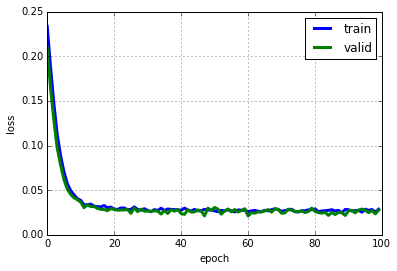

Reading subject 2 data
Reading subject 2 data. Done.
Reading subject 2 data
Reading subject 2 data. Done.
Train dimensions: X (1089538, 32) and Y (1089538, 6)
Validation dimensions: X (621956, 32) and Y (621956, 6)
  input             	[None, 32, 500]     	produces   16000 outputs
  Dropout1          	[None, 32, 500]     	produces   16000 outputs
  Dense1            	(None, 1024)        	produces    1024 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.23326       0.20809      1.12097  2.63s
      2       0.18650       0.16047      1.16220  2.62s
      3       0.14490       0.12219      1.18584  2.75s
      4       0.11193       0.09304      1.20310  2.61s
      5       0.08628       0.07011      1.23058  2.62s
      6       0.06883       0.05290      1.30119  2.61s
      7       0.05707       0.04370      1.30610  2.62s
      8       0

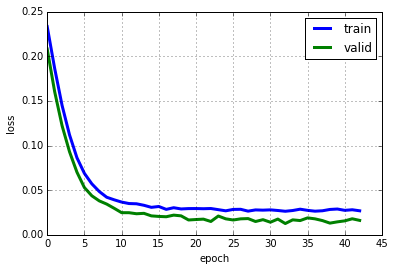

Reading subject 3 data


KeyboardInterrupt: 

In [108]:
for i in SUBJECTS: 
    net_factory = create_net1
    train(net_factory, i)